In [1]:
%load_ext autoreload
%autoreload 2

[2018-01-04 02:35:01,293] Making new env: CartPole-v0


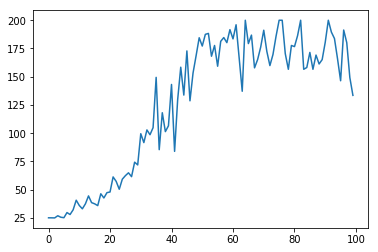

In [17]:
# Discrete task

from IPython import display
import matplotlib

from rl.algs import plotter
from rl.algs.pg import *


matplotlib.pyplot.ion()

NUM_TRAIN_ITERS = 100
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 1000
env = Environment(max_episode_steps=MAX_STEPS_PER_EPISODE)
policy = Policy(env.ob_dim, env.ac_dim)

plt = plotter.Plotter()
fig = plt.create_fig()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  plt.add_data(i, np.mean(m['r_per_eps']))

plt.line_plot(fig)
plt.render()


[2018-01-04 02:35:01,293] Making new env: CartPole-v0


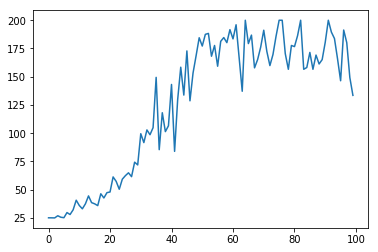

In [16]:
# Show an episode of the final policy
try:
  _ = env.sample_rollouts(policy.get_action, 1, render=True)
finally:
  env.env.render(close=True)


In [3]:
# Continuous task

from IPython import display
import matplotlib

import roboschool

from rl.algs import plotter
from rl.algs.pg import *


matplotlib.pyplot.ion()

NUM_TRAIN_ITERS = 100
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 1000
env = Environment(env_name='RoboschoolInvertedPendulum-v1',
                  max_episode_steps=MAX_STEPS_PER_EPISODE)
policy = ContinuousActionPolicy(env.ob_dim, env.ac_dim)

plt = plotter.Plotter()
fig = plt.create_fig()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  plt.add_data(i, np.mean(m['r_per_eps']))

plt.line_plot(fig)
plt.render()


In [8]:
# Show an episode of the final policy
try:
  _ = env.sample_rollouts(policy.get_action, 1, render=True)
finally:
  env.env.render(close=True)


In [57]:
# Scratchpad
import torch as th

mu = th.Tensor([0, 0.5, 1.0])
std = th.Tensor([1.0, 1.0, 1.0])

d = th.distributions.Normal(mu, std)
print(d)
a = th.Tensor([0, 0, 1.0])
th.exp(d.log_prob(a))

l = th.distributions.Normal(-0.2649, 1.1248).log_prob(-0.8086)
th.exp(th.Tensor([l]))



 0.3156
[torch.FloatTensor of size 1]